In [54]:
import pandas as pd
import os
import re
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import nltk
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
from nltk.corpus import stopwords
from pprint import pprint
import pyLDAvis.gensim
import pickle
import pyLDAvis
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sburc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sburc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sburc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
constituencies_df = pd.read_csv("constituencies_by_region.csv")
constituencies_df = constituencies_df[["PCON22NM", "constituency_by_region.shpRGN22NM"]]
constituencies_df["PCON22NM"] = constituencies_df["PCON22NM"].map(str.lower)
constituencies_df.rename(columns={"PCON22NM": "constName", "constituency_by_region.shpRGN22NM": "regionName"}, inplace=True)
constituencies_df.head()

,constName,regionName
0,aldershot,South East
1,aldridge-brownhills,West Midlands
2,altrincham and sale west,North West
3,amber valley,East Midlands
4,arundel and south downs,South East


In [3]:
const_dict = {k:v for k,v in zip(constituencies_df['constName'], constituencies_df["regionName"])}
print(const_dict)
print(len(const_dict))


{'aldershot': 'South East', 'aldridge-brownhills': 'West Midlands', 'altrincham and sale west': 'North West', 'amber valley': 'East Midlands', 'arundel and south downs': 'South East', 'ashfield': 'East Midlands', 'ashford': 'South East', 'ashton-under-lyne': 'North West', 'aylesbury': 'South East', 'banbury': 'South East', 'barking': 'London', 'barnsley central': 'Yorkshire and The Humber', 'barnsley east': 'Yorkshire and The Humber', 'barrow and furness': 'North West', 'basildon and billericay': 'East of England', 'basingstoke': 'South East', 'bassetlaw': 'East Midlands', 'bath': 'South West', 'batley and spen': 'Yorkshire and The Humber', 'battersea': 'London', 'beaconsfield': 'South East', 'beckenham': 'London', 'bedford': 'East of England', 'bermondsey and old southwark': 'London', 'berwick-upon-tweed': 'North East', 'bethnal green and bow': 'London', 'beverley and holderness': 'Yorkshire and The Humber', 'bexhill and battle': 'South East', 'bexleyheath and crayford': 'London', 'bi

In [4]:
questions_df = pd.read_csv('questionsQuery.csv', quotechar='"', skipinitialspace=True, encoding="utf-8")
print(questions_df.shape[1])

questions_df = questions_df.loc[:, ~questions_df.columns.str.contains('^Unnamed')]

def remove_whitespace(df):
    df.rename(str.strip, axis="columns", inplace=True)
    for i in df.columns:
        df[i] = df[i].str.strip()
        if i == "text":
            df[i] = df[i].map(lambda x: x[3:-4])


# REMOVE WHITE SPACE FROM DATAFRAME
print(questions_df.columns)
remove_whitespace(questions_df)
print(questions_df.columns)

questions_df.head()

16
Index(['question ', 'qnum ', 'text ', 'date ', 'person ', 'name ', 'surname ',
       'seatIncumbency ', 'seat ', 'constituency ', 'house ', 'houseName ',
       'seatIncumbencyStartDate ', 'constituencyName ',
       'constituencyStartDate '],
      dtype='object')
Index(['question', 'qnum', 'text', 'date', 'person', 'name', 'surname',
       'seatIncumbency', 'seat', 'constituency', 'house', 'houseName',
       'seatIncumbencyStartDate', 'constituencyName', 'constituencyStartDate'],
      dtype='object')


,question,qnum,text,date,person,name,surname,seatIncumbency,seat,constituency,house,houseName,seatIncumbencyStartDate,constituencyName,constituencyStartDate
0,https://id.parliament.uk/0IwOO533,903422,Which three departments had the lowest proport...,2023-01-05+00:00,https://id.parliament.uk/Vs3bGLNz,Philip,Hollobone,https://id.parliament.uk/wiR0TXEx,https://id.parliament.uk/tpDcfKEU,https://id.parliament.uk/79YObEMl,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,Kettering,2010-05-06+01:00
1,https://id.parliament.uk/dRJ9254g,117748,"To ask the Secretary of State for Foreign, Com...",2023-01-06+00:00,https://id.parliament.uk/eD0yd5Ec,Catherine,West,https://id.parliament.uk/TbtymCvC,https://id.parliament.uk/cR4IWVwp,https://id.parliament.uk/H2TVOJgH,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,Hornsey and Wood Green,2010-05-06+01:00
2,https://id.parliament.uk/e4IDRkKi,117410,"To ask the Secretary of State for Foreign, Com...",2023-01-06+00:00,https://id.parliament.uk/RlIqlixq,Timothy,Loughton,https://id.parliament.uk/UWWa5GU5,https://id.parliament.uk/OEV2U2ZQ,https://id.parliament.uk/YqIfQuKs,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,East Worthing and Shoreham,2010-05-06+01:00
3,https://id.parliament.uk/rXZ0r1JW,117477,"To ask the Secretary of State for Foreign, Com...",2023-01-06+00:00,https://id.parliament.uk/1DzMUkBy,Fabian,Hamilton,https://id.parliament.uk/I8imum8M,https://id.parliament.uk/8dnnjjvi,https://id.parliament.uk/EH8hmrNu,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,Leeds North East,2010-05-06+01:00
4,https://id.parliament.uk/SmC4cGhg,117777,To ask the Secretary of State for Health and S...,2023-01-06+00:00,https://id.parliament.uk/tOfis7j9,Sarah,Olney,https://id.parliament.uk/XQNx9njJ,https://id.parliament.uk/UVpLA3KR,https://id.parliament.uk/MDExJLK4,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,Richmond Park,2010-05-06+01:00


In [5]:
# COUNT AND REMOVE NON-MPs
total_questions = questions_df.shape[0]
questions_df.dropna(subset=['seatIncumbency', 'seat', 'constituency', 'house', 'houseName',
       'seatIncumbencyStartDate', 'constituencyName', 'constituencyStartDate'], inplace=True)
questions_df.reset_index(drop=True, inplace=True)

mps_only_count = questions_df.shape[0]

print("number of non-mp questions:", total_questions - mps_only_count)

number of non-mp questions: 2393


In [6]:
questions_df = questions_df[['text', "constituencyName"]]
questions_df['constituencyName'] = questions_df['constituencyName'].map(str.lower)

# assign region to each question
questions_df['regionName'] = questions_df.constituencyName.map(lambda x: const_dict[x])

questions_df.head()

,text,constituencyName,regionName
0,Which three departments had the lowest proport...,kettering,East Midlands
1,"To ask the Secretary of State for Foreign, Com...",hornsey and wood green,London
2,"To ask the Secretary of State for Foreign, Com...",east worthing and shoreham,South East
3,"To ask the Secretary of State for Foreign, Com...",leeds north east,Yorkshire and The Humber
4,To ask the Secretary of State for Health and S...,richmond park,London


In [7]:
# REMOVE PUNCTUATION AND CONVERT TO LOWER CASE

questions_df['text_processed'] = questions_df['text'].map(lambda x: re.sub('[,\\.!\/?:;()\[\]]', "", x))
questions_df['text_processed'] = questions_df['text_processed'].map(lambda x: x.lower())

print(questions_df.loc[0, "text_processed"])
questions_df.head()

which three departments had the lowest proportion of staff attending the office in january 2023


<>:3: DeprecationWarning: invalid escape sequence '\/'
<>:3: DeprecationWarning: invalid escape sequence '\/'
C:\Users\sburc\AppData\Local\Temp\ipykernel_33124\3744966746.py:3: DeprecationWarning: invalid escape sequence '\/'
  questions_df['text_processed'] = questions_df['text'].map(lambda x: re.sub('[,\\.!\/?:;()\[\]]', "", x))


,text,constituencyName,regionName,text_processed
0,Which three departments had the lowest proport...,kettering,East Midlands,which three departments had the lowest proport...
1,"To ask the Secretary of State for Foreign, Com...",hornsey and wood green,London,to ask the secretary of state for foreign comm...
2,"To ask the Secretary of State for Foreign, Com...",east worthing and shoreham,South East,to ask the secretary of state for foreign comm...
3,"To ask the Secretary of State for Foreign, Com...",leeds north east,Yorkshire and The Humber,to ask the secretary of state for foreign comm...
4,To ask the Secretary of State for Health and S...,richmond park,London,to ask the secretary of state for health and s...


In [8]:
unique_words = set().union(*questions_df['text_processed'].map(lambda x: x.split()))
print(unique_words)
print(f"unique words: {len(unique_words)}")

{'182779', 'netherlands', '-', 'reset', 'old', 'post-legislative', 'recognition', 'recommending', 'earthquakes', 'uk-eu', 'responsible', 'intrauterine', 'llanelli', 'cited', 'post-implementation', 'miners’', 'industries', 'financially', 'evidential', 'eco-system', 'school-system', 'accelerator', 'sickle', 'self-disconnect', '2565', 'temperature', 'hungary', 'lavatories', 'resist', 'liquids', '146842', "freedom's", 'uk-japan', "premises'", 'drainage', 'over', 'caught', 'fell', 'agree', '176701', 'benítez', 'stones', "natasha's", 'deptford', 'abattoirs', 'drink', 'openness', 'experimental', '191564', 'western', 'rm3774', 'fought', 'ons', 'religion', 'mpam046547022', 'diving', 'glycerin', 'tangaroa', '148625', 'policynhs', '20161105', 'underrepresented', 'dentaid', 'milk', 'lawrence', 'inclination', 'glasshouses', 'whilst', 'afghans', 'feltwell', 'created', 'net', 'rm', 'developments', '162118', 'literacy', 'retrain', 'estimated', 'finsbury', 'fan', 'lasso', '119208on', 'joins', 'commons'

c:\Users\sburc\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\sburc\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\sburc\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
c:\Users\sburc\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pil

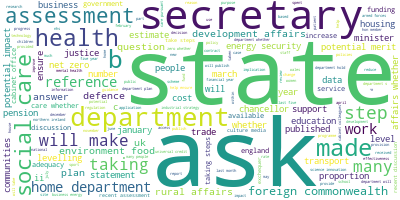

In [9]:
# code adapted from https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
long_string = ",".join(questions_df['text_processed'].values)

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color="steelblue")
wordcloud.generate(long_string)

wordcloud.to_image()


In [56]:
# Code adapted from https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html
stop_words = stopwords.words("english")
stop_words.extend(["ask", "state", "secretary", "department", "made", "whether", "many", "make", "question", "answer"])

lemmatizer = WordNetLemmatizer()

def questions_to_tokens(questions):
    return [[token for token in simple_preprocess(str(q), deacc=True)] for q in questions]

def lemmatize_tokens(questions):
    return [[lemmatizer.lemmatize(token) for token in q] for q in questions]

def clean_tokens(questions):
    return [[token for token in q if token not in stop_words and len(token) > 2] for q in questions]

def parse_questions(texts):
    return [[lemmatizer.lemmatize(word) for word in simple_preprocess(str(q), deacc=True) if lemmatizer.lemmatize(word) not in stop_words and len(lemmatizer.lemmatize(word)) > 2] for q in texts]

def add_ngrams(questions):
    bigram = Phrases(questions, min_count=20)
    for idx in range(len(questions)):
        for token in bigram[questions[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                questions[idx].append(token)
    return questions
    

# get list of questions
questions = questions_df.text_processed.values.tolist()

# turn questions into list of words (tokens) and remove stop words
words = questions_to_tokens(questions)
words = lemmatize_tokens(words)
words = clean_tokens(words)
words = add_ngrams(words)
print(questions_df.loc[0, "text_processed"])
print(words[:1][0])

which three departments had the lowest proportion of staff attending the office in january 2023
['three', 'lowest', 'proportion', 'staff', 'attending', 'office', 'january']


In [57]:
counter = Counter(words[0])
for question in words[1:]:
    counter.update(question)

counter.most_common(100)

[('health', 6043),
 ('care', 5579),
 ('assessment', 5361),
 ('social', 5087),
 ('step', 4768),
 ('health_social', 4648),
 ('affair', 3576),
 ('taking', 3295),
 ('energy', 2980),
 ('home', 2956),
 ('potential', 2924),
 ('plan', 2789),
 ('year', 2749),
 ('development', 2445),
 ('step_taking', 2442),
 ('work', 2434),
 ('defence', 2404),
 ('reference', 2250),
 ('business', 2180),
 ('foreign', 2101),
 ('recent', 2075),
 ('assessment_potential', 2064),
 ('support', 2061),
 ('people', 2057),
 ('education', 2006),
 ('food', 1988),
 ('service', 1980),
 ('commonwealth', 1966),
 ('foreign_commonwealth', 1931),
 ('development_affair', 1911),
 ('government', 1772),
 ('impact', 1744),
 ('environment', 1739),
 ('last', 1677),
 ('pursuant', 1671),
 ('rural', 1668),
 ('security', 1649),
 ('rural_affair', 1599),
 ('environment_food', 1596),
 ('pension', 1592),
 ('housing', 1517),
 ('policy', 1515),
 ('discussion', 1492),
 ('trade', 1490),
 ('work_pension', 1474),
 ('published', 1444),
 ('funding', 1437)

In [58]:
unique_words = set().union(*words)
print(unique_words)
print(f"unique words: {len(unique_words)}")

{'old', 'netherlands', 'reset', 'intrauterine', 'recognition', 'recommending', 'responsible', 'llanelli', 'cited', 'financially', 'evidential', 'ass', 'sickle', 'accelerator', 'temperature', 'hungary', 'resist', 'drainage', 'emp', 'fell', 'caught', 'agree', 'strike_minimum', 'deptford', 'drink', 'experimental', 'openness', 'doorbell', 'western', 'fought', 'ons', 'religion', 'diving', 'glycerin', 'tangaroa', 'policynhs', 'dentaid', 'inclination', 'milk', 'lawrence', 'whilst', 'feltwell', 'created', 'net', 'retrain', 'literacy', 'estimated', 'finsbury', 'fan', 'lasso', 'unannounced', 'shotgun', 'alireza', 'revenge', 'generator', 'march', 'fulham', 'cutter', 'adjusting', 'poultry', 'whereabouts', 'add', 'rochdale', 'vetted', 'charter', 'altering', 'vaccine_damage', 'ukapy', 'release_entitled', 'dinefwr', 'architecture', 'registration', 'watershed', 'enabling', 'accusation', 'crown_court', 'abolishing', 'sourced', 'liposuction', 'deviated', 'conveyancing', 'hgv', 'unpublished', 'entitlemen

In [59]:
# Code adapted from https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
# create a dictonary of ids from the words in the corpus (list of questions)
id2word = corpora.Dictionary(words)
questions = words
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=20, no_above=0.5)

# convert each question into bag of words (where words are ids based on dictionary)
corpus = [id2word.doc2bow(question) for question in questions]
# train_corpus = [id2word.doc2bow(question) for question in questions_train]
# test_corpus = [id2word.doc2bow(question) for question in questions_test]

print(corpus[:1][0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [60]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2524
Number of documents: 24431


In [50]:
import logging
for handler in logging.root.handlers[:]:
   logging.root.removeHandler(handler)
logging.basicConfig(filename="lda_model.log", format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [27]:
num_topics = 10
iters = 200
passes = 40
chunksize = questions_df.shape[0] // 2
random_state = 42

base_model = gensim.models.LdaModel(corpus=corpus, 
                                       id2word=id2word, 
                                       num_topics=num_topics, random_state=random_state)

pprint(base_model.print_topics())
doc_lda = base_model[corpus]

[(0,
  '0.039*"reference" + 0.025*"published" + 0.020*"office" + 0.020*"minister" + '
  '0.018*"government" + 0.018*"plans" + 0.017*"march" + 0.015*"report" + '
  '0.014*"publish" + 0.013*"cabinet"'),
 (1,
  '0.051*"work" + 0.033*"last" + 0.033*"pensions" + 0.026*"years" + '
  '0.022*"estimate" + 0.020*"justice" + 0.017*"people" + 0.017*"year" + '
  '0.017*"number" + 0.015*"proportion"'),
 (2,
  '0.067*"assessment" + 0.056*"education" + 0.038*"potential" + '
  '0.026*"transport" + 0.024*"schools" + 0.021*"merits" + 0.021*"impact" + '
  '0.019*"policies" + 0.018*"implications" + 0.016*"school"'),
 (3,
  '0.119*"steps" + 0.083*"taking" + 0.033*"help" + 0.031*"housing" + '
  '0.030*"ensure" + 0.026*"take" + 0.026*"communities" + 0.024*"levelling" + '
  '0.016*"support" + 0.016*"plans"'),
 (4,
  '0.079*"development" + 0.069*"affairs" + 0.066*"foreign" + '
  '0.064*"commonwealth" + 0.018*"discussions" + 0.017*"recent" + '
  '0.014*"international" + 0.011*"northern" + 0.011*"ireland" + '
  '

In [28]:
cm = gensim.models.coherencemodel.CoherenceModel(model=base_model, texts=questions,\
                                                     dictionary=id2word, coherence='c_v')
print(cm.get_coherence())

c:\Users\sburc\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
c:\Users\sburc\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
c:\Users\sburc\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and

0.453522132130454


In [22]:
# Code from https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2
cv_coherence = []
umass_coherence = []
perplexity = []
for k in range(5,25):
    ldamodel = gensim.models.LdaModel(corpus, num_topics=k, alpha="auto", eta="auto", id2word = id2word, passes=40,\
                   iterations=200, random_state=random_state, eval_every = None)
    
    cv_cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=questions,\
                                                     dictionary=id2word, coherence='c_v')
    umass_cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=questions,\
                                                     dictionary=id2word, coherence='u_mass')
    
    print(k, cv_cm.get_coherence(), umass_cm.get_coherence())
    cv_coherence.append((k,cv_cm.get_coherence()))
    umass_coherence.append((k, umass_cm.get_coherence()))

5 0.4499748954840442 -6.545744266686161
6 0.4324554056650211 -4.988802413315692
7 0.43313899083149615 -7.145197103866053
8 0.47299453083818954 -7.997507522791263
9 0.3850997287085881 -5.323846959318432
10 0.46738495855977147 -7.793308671868424
11 0.4491857064945375 -7.30596607328778
12 0.44693028065375645 -8.38199010264612
13 0.4628838531826952 -10.223183992665978
14 0.45656167682907567 -8.054324972549091
15 0.42963097281232837 -8.591683851185026
16 0.43629768844116545 -7.939732434095273
17 0.4266272946926971 -7.335965264931322
18 0.41524475924348964 -7.10348624483442
19 0.4353460732708336 -8.820063095027415
20 0.3874474707141399 -6.918124816517033
21 0.4279005306442134 -8.063098465844286
22 0.4148328725515311 -6.645511306179336
23 0.44549084808187694 -7.559341589039831
24 0.4166225094587653 -8.169480809382385


In [23]:
print(cv_coherence)
print(umass_coherence)

[(5, 0.4499748954840442), (6, 0.4324554056650211), (7, 0.43313899083149615), (8, 0.47299453083818954), (9, 0.3850997287085881), (10, 0.46738495855977147), (11, 0.4491857064945375), (12, 0.44693028065375645), (13, 0.4628838531826952), (14, 0.45656167682907567), (15, 0.42963097281232837), (16, 0.43629768844116545), (17, 0.4266272946926971), (18, 0.41524475924348964), (19, 0.4353460732708336), (20, 0.3874474707141399), (21, 0.4279005306442134), (22, 0.4148328725515311), (23, 0.44549084808187694), (24, 0.4166225094587653)]
[(5, -6.545744266686161), (6, -4.988802413315692), (7, -7.145197103866053), (8, -7.997507522791263), (9, -5.323846959318432), (10, -7.793308671868424), (11, -7.30596607328778), (12, -8.38199010264612), (13, -10.223183992665978), (14, -8.054324972549091), (15, -8.591683851185026), (16, -7.939732434095273), (17, -7.335965264931322), (18, -7.10348624483442), (19, -8.820063095027415), (20, -6.918124816517033), (21, -8.063098465844286), (22, -6.645511306179336), (23, -7.55934

In [24]:
x_val = [x[0] for x in cv_coherence]
cv_val = [x[1] for x in cv_coherence]
umass_val = [x[1] for x in umass_coherence]

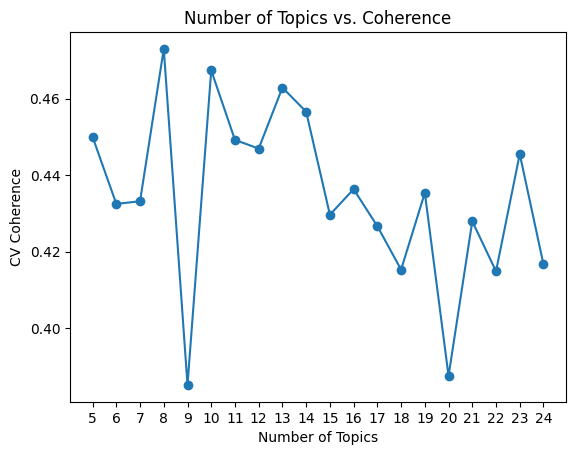

In [25]:
plt.plot(x_val,cv_val)
plt.scatter(x_val,cv_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('CV Coherence')
plt.xticks(x_val)
plt.show()

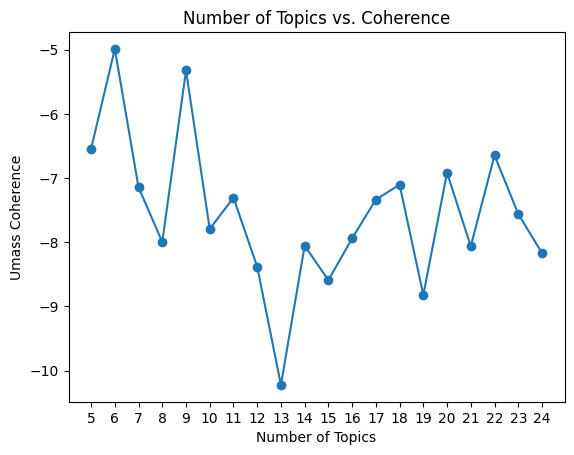

In [26]:
plt.plot(x_val,umass_val)
plt.scatter(x_val,umass_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Umass Coherence')
plt.xticks(x_val)
plt.show()

In [61]:
# TRAIN THE MODEL (adjusted parameters)
num_topics = 8
iters = 200 # number of iterations over each document
passes = 40 # number of passes through the entire corpus

lda_model = gensim.models.LdaModel(corpus=corpus, 
                                       id2word=id2word, alpha="auto", eta="auto", 
                                       num_topics=num_topics, iterations=iters, passes=passes, random_state=random_state)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"reference" + 0.029*"education" + 0.028*"published" + 0.024*"march" + '
  '0.019*"grant" + 0.018*"plan" + 0.018*"assessment" + 0.017*"school" + '
  '0.016*"government" + 0.016*"medium"'),
 (1,
  '0.071*"defence" + 0.056*"home" + 0.024*"service" + 0.023*"hold" + '
  '0.021*"asylum" + 0.016*"family" + 0.015*"force" + 0.015*"accommodation" + '
  '0.013*"pursuant" + 0.012*"information"'),
 (2,
  '0.049*"year" + 0.041*"work" + 0.035*"last" + 0.028*"pension" + '
  '0.025*"work_pension" + 0.020*"estimate" + 0.019*"justice" + 0.019*"time" + '
  '0.017*"number" + 0.017*"financial"'),
 (3,
  '0.037*"minister" + 0.035*"trade" + 0.034*"office" + 0.032*"business" + '
  '0.028*"pursuant" + 0.027*"business_trade" + 0.019*"cabinet" + '
  '0.017*"funding" + 0.016*"minister_cabinet" + 0.013*"july"'),
 (4,
  '0.113*"health" + 0.103*"care" + 0.094*"social" + 0.087*"health_social" + '
  '0.021*"assessment" + 0.016*"adequacy" + 0.015*"assessment_adequacy" + '
  '0.011*"service" + 0.010*"patien

In [62]:
cm = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=questions,\
                                                     dictionary=id2word, coherence='c_v')
print(cm.get_coherence())

0.452559123614662


ANAYLSE RESULTS

In [63]:
# Code adapted from https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join(f"./results/ldavis_prepared_{str(num_topics)}")

# Transform model, corpus and dictionary into visualization
if True:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, "wb") as f:
        pickle.dump(LDAvis_prepared, f)

# load pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, "rb") as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, f"./results/ldavis_prepared_{str(num_topics)}.html")

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.122759 -0.019652       1        1  17.599578
0      0.117499  0.132538       2        1  14.874362
2     -0.237379 -0.007074       3        1  13.211074
4      0.073319 -0.107828       4        1  13.020246
6     -0.074789 -0.346614       5        1  11.024879
5      0.289039  0.025829       6        1  10.921638
3     -0.105853  0.244658       7        1  10.852168
1     -0.184595  0.078143       8        1   8.496055, topic_info=               Term         Freq        Total Category  logprob  loglift
37           health  5892.000000  5892.000000  Default  30.0000  30.0000
35             care  5402.000000  5402.000000  Default  29.0000  29.0000
30             step  4959.000000  4959.000000  Default  28.0000  28.0000
45           social  4937.000000  4937.000000  Default  27.0000  27.0000
38    health_social  4559.000000  4559.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
378          scheme   341.998536  1342.986149   Topic8  -4.6031   1.0977
51            child   285.252540   920.450647   Topic8  -4.7845   1.2941
1205          april   250.473557   637.996929   Topic8  -4.9145   1.5306
62           people   295.669616  2011.416202   Topic8  -4.7487   0.5482
357          system   233.396788   549.209815   Topic8  -4.9852   1.6098

[391 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
155       1  0.103390      access
155       2  0.098761      access
155       3  0.061725      access
155       4  0.362637      access
155       5  0.371896      access
...     ...       ...         ...
1062      4  0.995534   workforce
17        3  0.949870        year
17        7  0.049820        year
18        3  0.997876  year_since
674       1  0.999382        zero

[528 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 3, 5, 7, 6, 4, 2])

In [ ]:
questions_df['regionName'] = questions_df['constituencyName'].map(lambda x: const_dict[x])

In [ ]:
# get list of topic probabilities for each question
question_topics = []
for question in corpus:
    topics = lda_model.get_document_topics(question)
    question_topics.append(topics)

question_topics

In [ ]:
# get average question topics for each region
